In [ ]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd

In [ ]:
!mkdir -p ~/.kaggle



In [ ]:
from google.colab import files
files.upload()




Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pranavparvekar","key":"fe3cac3275c3aed64e1ebac8d8c15be0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json


In [ ]:
!kaggle config set -n apikey -v ~/.kaggle/kaggle.json

- apikey is now set to: /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.15G/4.16G [00:37<00:00, 75.1MB/s]
100% 4.16G/4.16G [00:37<00:00, 118MB/s] 


In [ ]:
path_to_zip_file = "brats20-dataset-training-validation.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("brats20-dataset-training-validation")

In [ ]:
old_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# Renaming the file
try:
    os.rename(old_name, new_name)
    print("The file has been successfully renamed")
except FileNotFoundError:
    print("Maybe you have already renamed the file or the file is not misspelled on the dataset anymore")

The file has been successfully renamed


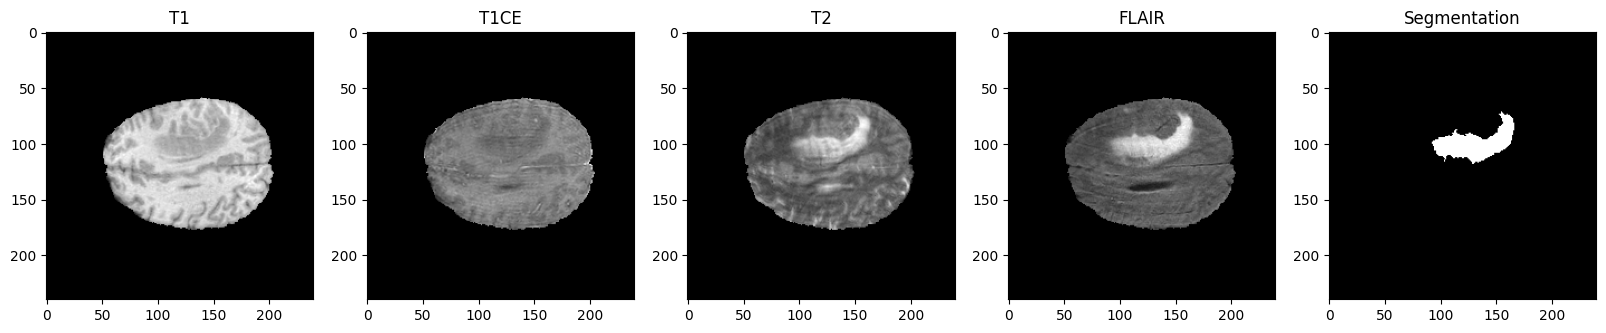

In [ ]:

sample_path = 'brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'


t1_img=nib.load(sample_path + 't1.nii')
t1ce_img=nib.load(sample_path + 't1ce.nii')
t2_img=nib.load(sample_path + 't2.nii')
flair_img=nib.load(sample_path + 'flair.nii')
seg_img=nib.load(sample_path + 'seg.nii')


t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()


slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()



In [ ]:

# Modality shape
print(t1_data.shape)

# Segmentation shape
print(seg_data.shape)

(240, 240, 155)
(240, 240, 155)


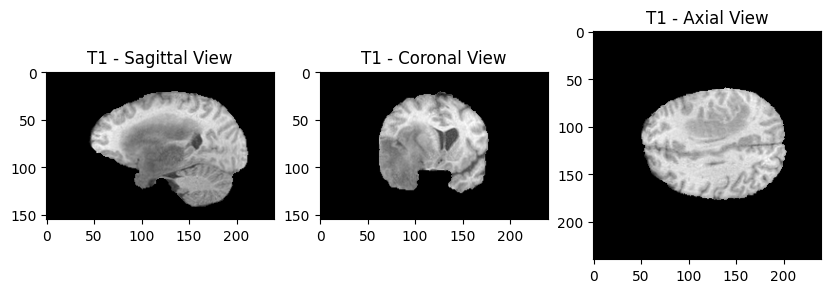

In [ ]:

slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))


axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

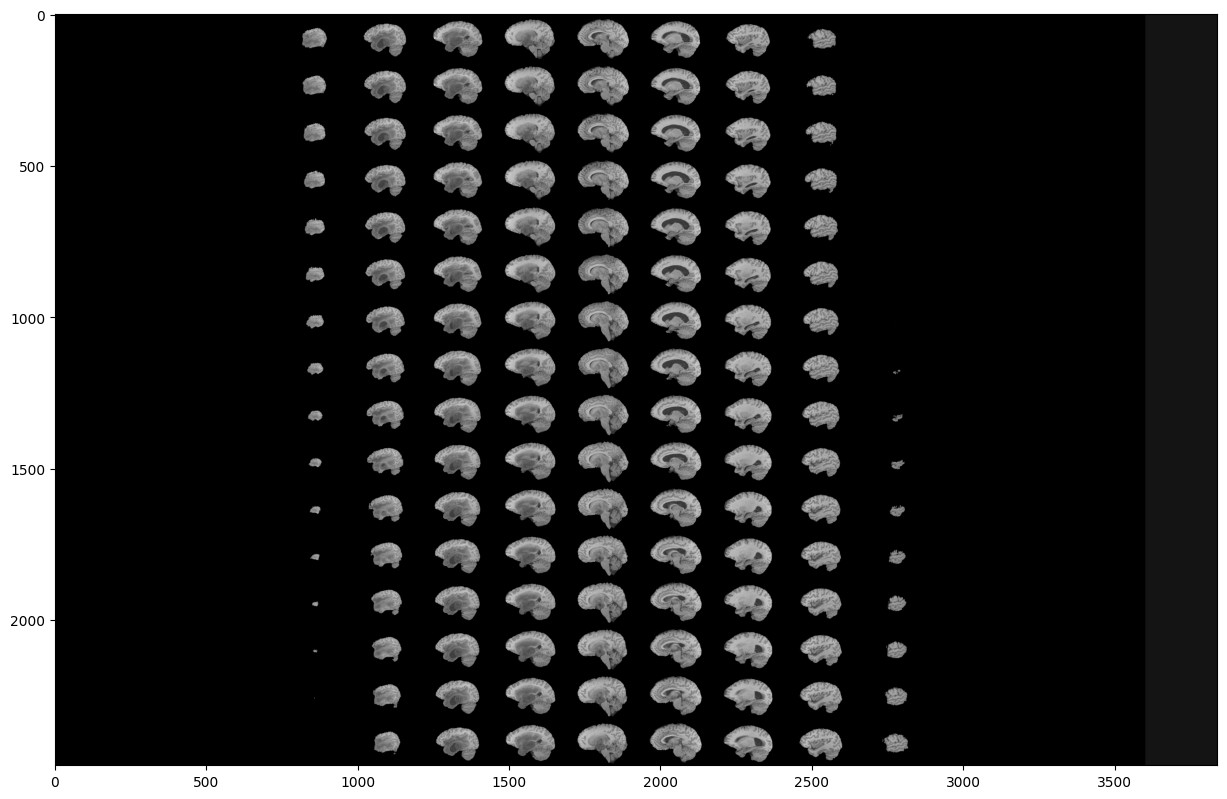

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[:,:,:]), 90, resize=True), cmap ='gray')



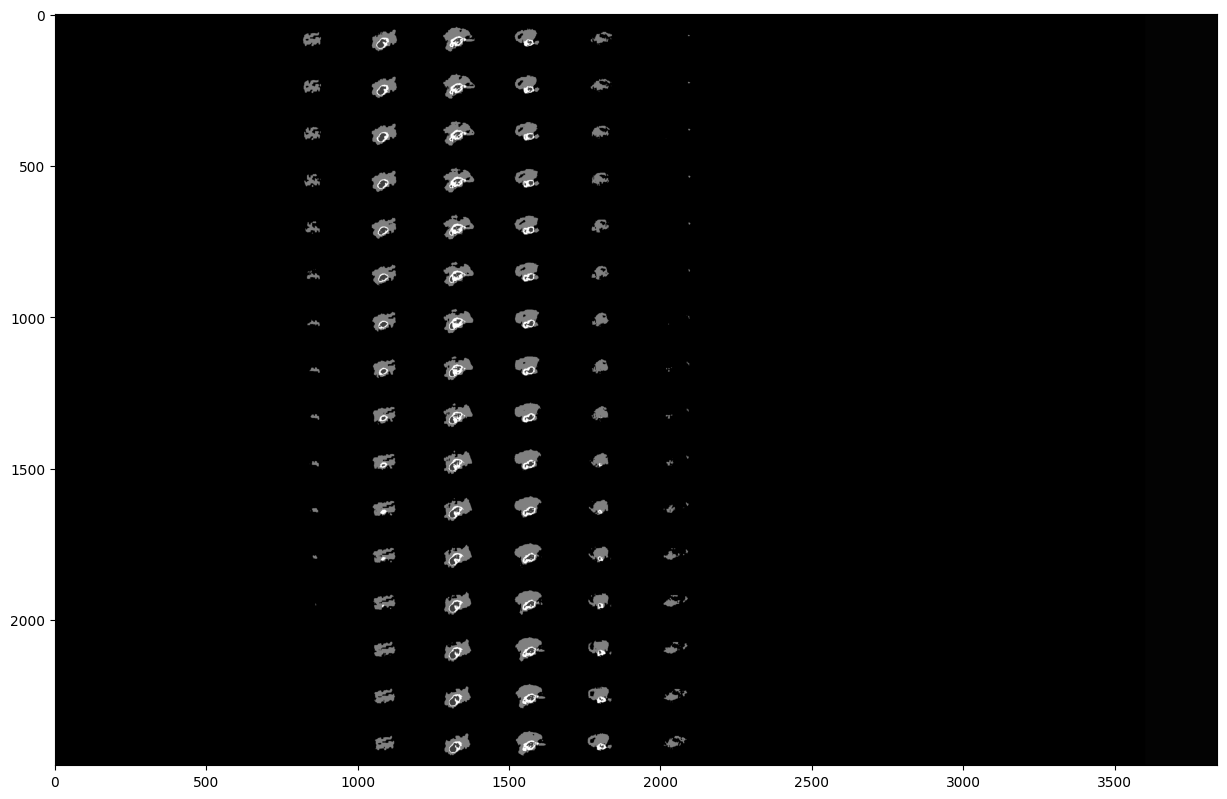

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(seg_data[:,:,:]), 90, resize=True), cmap ='gray')

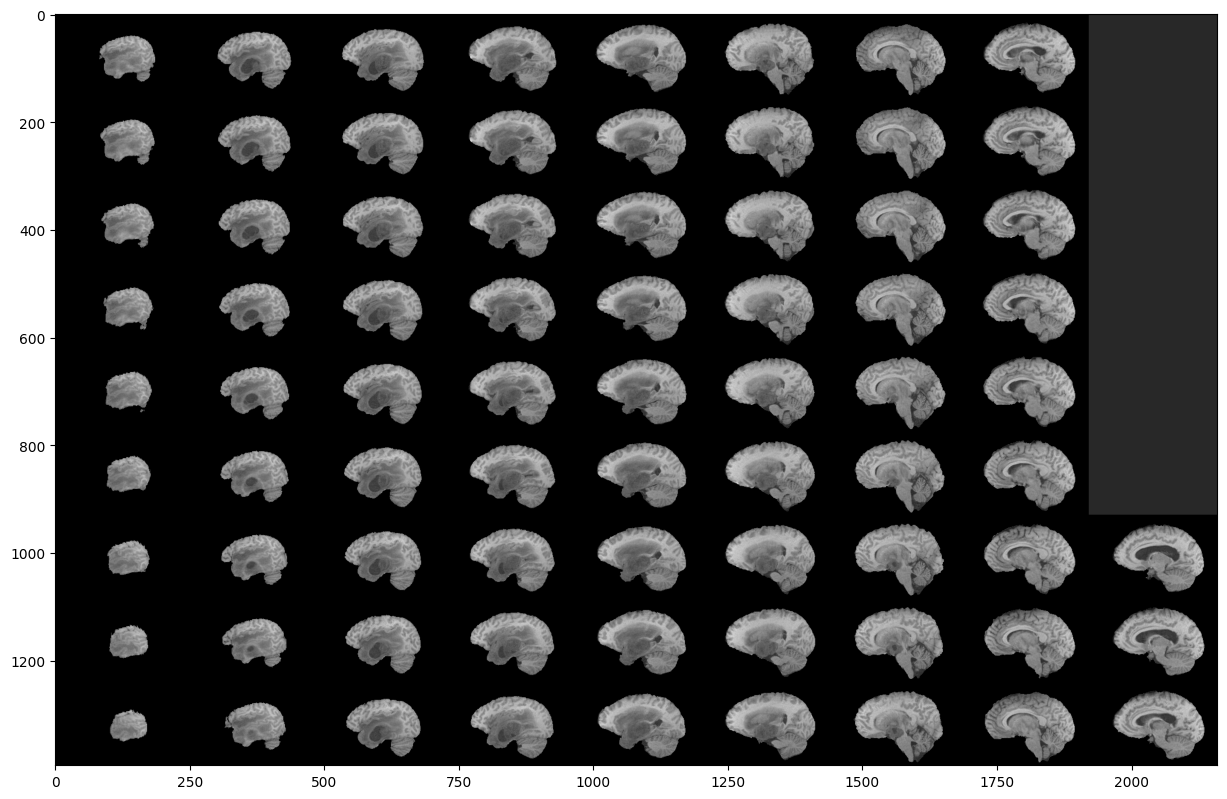

In [ ]:

fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[60:135,:,:]), 90, resize=True), cmap ='gray')

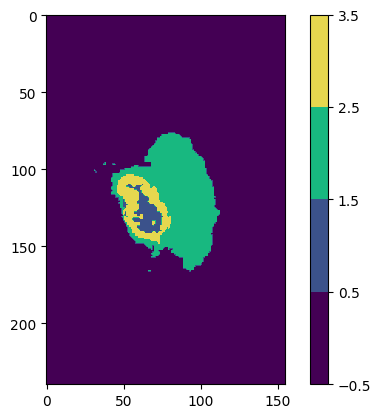

In [ ]:

# Plot a segmantation
some_seg_img = nib.load("brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

In [ ]:
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))

    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


In [ ]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

[8716021   15443  168794   27742]


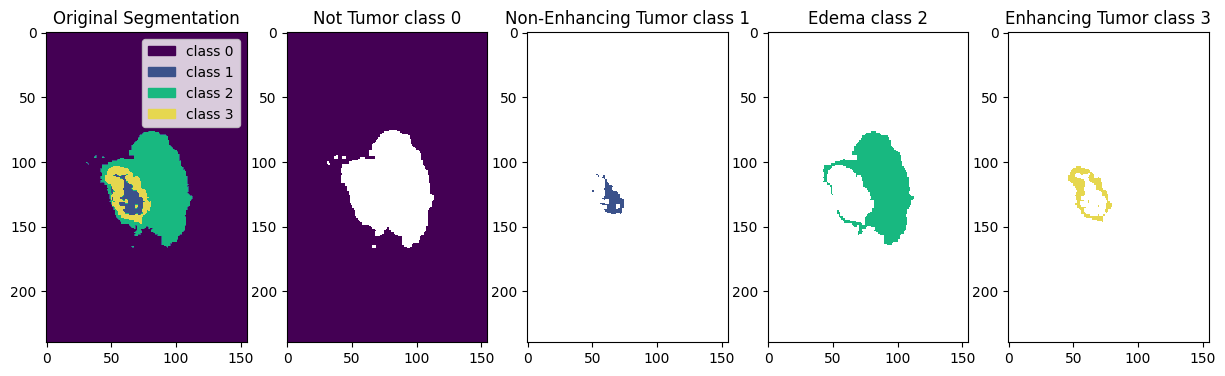

In [ ]:
# Deletion of class 0
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.copy()
seg_3[seg_3 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation')
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0')

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1')

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2')

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3')

plt.show()

In [ ]:
VOLUME_START_AT = 60
VOLUME_SLICES = 75

In [ ]:
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 371


In [ ]:

samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

In [ ]:
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


In [ ]:

IMG_SIZE = 128

from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        for c, i in enumerate(Batch_ids):


            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'


            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()


            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))


        return X/np.max(X), Y

training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

In [ ]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

In [ ]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-6):
    class_num = 4
    dice = []

    for i in range(class_num):
        y_true_f = tf.keras.backend.flatten(y_true[:,:,:,i])
        y_pred_f = tf.keras.backend.flatten(y_pred[:,:,:,i])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
        dice.append((2. * intersection + smooth) / (union + smooth))

    return tf.reduce_mean(dice)


def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[dice_coef])


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.000001,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model_{epoch:02d}_{val_loss:.6f}.weights.h5',
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    ),
    CSVLogger('training.log', separator=',', append=False)
]


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(training_generator,
          epochs=30,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
           validation_data=valid_generator)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - dice_coef: 0.2542 - loss: 0.2418
Epoch 1: val_loss improved from inf to 0.07917, saving model to model_01_0.079173.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 214s 648ms/step - dice_coef: 0.2542 - loss: 0.2413 - val_dice_coef: 0.2744 - val_loss: 0.0792 - learning_rate: 0.0010
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.07917
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - val_dice_coef: 0.2744 - val_loss: 0.0792 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - dice_coef: 0.2768 - loss: 0.0821
Epoch 3: val_loss improved from 0.07917 to 0.07566, saving model to model_03_0.075663.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 168s 548ms/step - dice_coef: 0.2768 - loss: 0.0821 - val_dice_coef: 0.2782 - val_loss: 0.0757 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: val_loss did not improve from 0.07566
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - val_dice_coef: 0.2782 - val_loss: 0.0757 - learning_rate: 0.0010
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - dice_coef: 0.2810 - loss: 0.0770
Epoch 5: val_loss improved from 0.07566 to 0.06862, saving model to model_05_0.068618.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 184s 544ms/step - dice_coef: 0.2810 - 

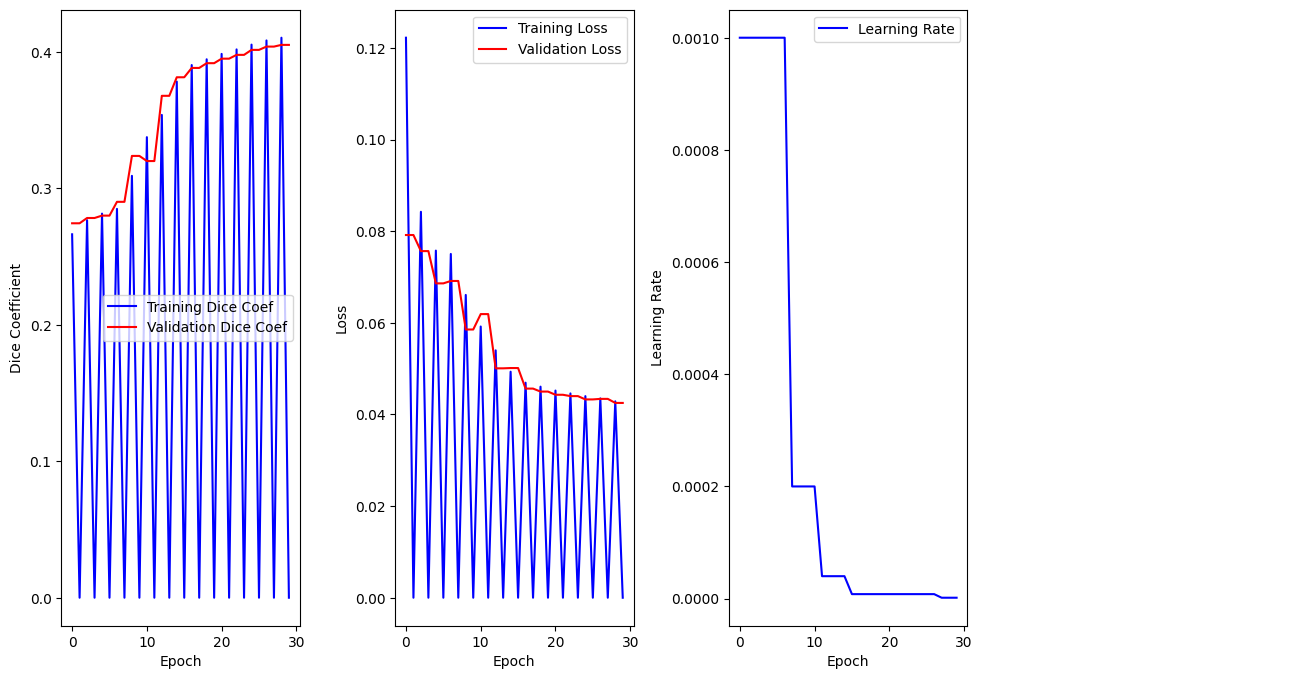

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

# Plot dice coefficient
axs[0].plot(history['epoch'], history['dice_coef'], 'b', label='Training Dice Coef')
axs[0].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation Dice Coef')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Dice Coefficient')
axs[0].legend()

# Plot loss
axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Plot learning rate
axs[2].plot(history['epoch'], history['learning_rate'], 'b', label='Learning Rate')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')
axs[2].legend()

# If there is a placeholder fourth plot, you can leave it empty or use another metric if available
axs[3].axis('off')  # Turn off the fourth plot

plt.subplots_adjust(wspace=0.4)
plt.show()


In [ ]:
def predict_segmentation(sample_path):

    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'


    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [ ]:
print(history.columns)


Index(['epoch', 'dice_coef', 'learning_rate', 'loss', 'val_dice_coef',
       'val_loss'],
      dtype='object')


In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):

    random_sample = random.choice(samples_list)


    random_sample_path = os.path.join(data_path, random_sample, random_sample)


    predicted_seg = predict_segmentation(random_sample_path)


    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()


    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    all = predicted_seg[slice_to_plot,:,:,1:4]
    zero = predicted_seg[slice_to_plot,:,:,0]
    first = predicted_seg[slice_to_plot,:,:,1]
    second = predicted_seg[slice_to_plot,:,:,2]
    third = predicted_seg[slice_to_plot,:,:,3]


    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))


    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')

    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')


    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')


    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')


    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')

    plt.subplots_adjust(wspace=0.8)

    plt.show()

In [ ]:
def show_post_processed_segmentations(sample, slice_to_plot, cmap, norm):

    sample_path = os.path.join(data_path, sample, sample)

    predicted_seg = predict_segmentation(sample_path)

    seg_path = sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)


    seg[seg==4] = 3

    seg[seg==0] = np.nan

    my_pred = np.argmax(predicted_seg, axis=3)
    my_pred = my_pred[slice_to_plot, :, :]


    my_pred = my_pred.astype(float)
    my_pred[my_pred == 0] = np.nan

    all = predicted_seg[slice_to_plot,:,:,1:4]

    print("Patient number: ", sample)
    fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    axstest[1].imshow(all)
    axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')

    axstest[2].imshow(my_pred, cmap, norm)
    axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')

    plt.subplots_adjust(wspace=0.8)

    plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Patient number:  BraTS20_Training_266


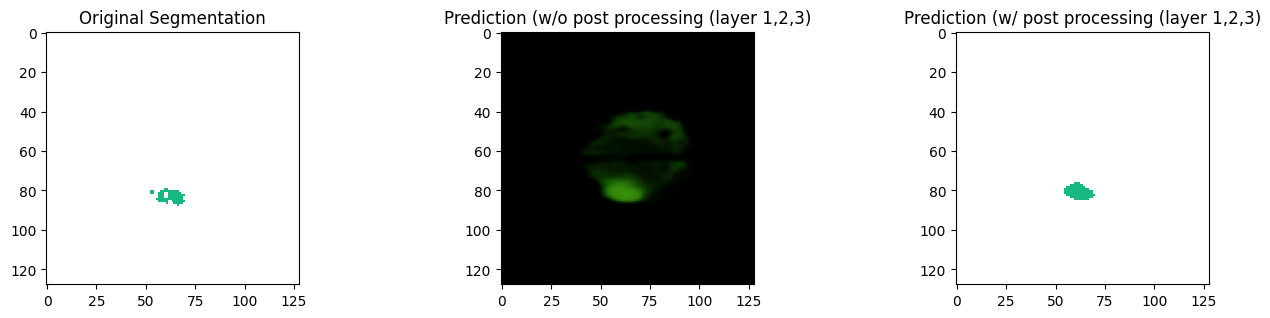

In [ ]:
show_post_processed_segmentations(sample = "BraTS20_Training_266", slice_to_plot=60, cmap=cmap, norm=norm)

In [ ]:


results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

results_list = zip(results, descriptions)

print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 413ms/step - accuracy: 0.9829 - loss: 0.0659

Model evaluation on the test set:
Loss : 0.0629
Accuracy : 0.9846
